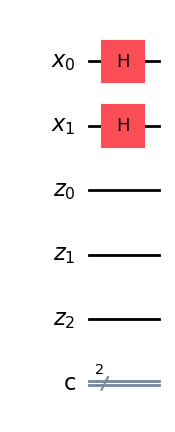

In [1]:
# Step 1: Import and create registers
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT

# Create input (x), value (z) and classical (c) registers
n_input = 2    # Input qubits: x0, x1
m_value = 3    # Value qubits: encoding f(x) values
x = QuantumRegister(n_input, name='x')
z = QuantumRegister(m_value, name='z')
c = ClassicalRegister(n_input, name='c')  # Only measure input qubits
qc = QuantumCircuit(x, z, c)

# Step 2: Apply Hadamard to input
qc.h(x)


qc.draw('mpl')

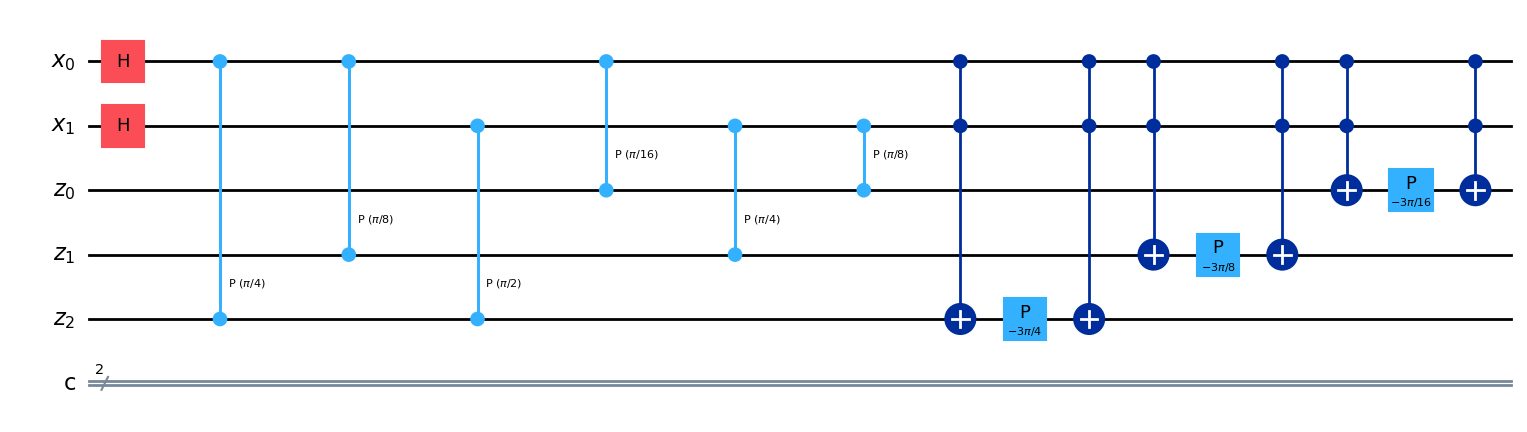

In [2]:
# Step 3: Encode QUBO function using controlled phase rotations

import numpy as np


coefficients = {
    (0,): 1,        # +1 * x0
    (1,): 2,        # +2 * x1
    (0,1): -3       # -3 * x0 * x1
}

for key, value in coefficients.items(): #loop through the each monomial 
    theta = 2 * np.pi * value / (2**m_value)  # each co-eff into rotation angle, divided by 2**m_value(8) coz it can store numbers upto this value
    controls = [x[i] for i in key] # select control qubit from i/p
    targets = z

    if len(controls) == 1: #for single variable
        for j in range(m_value):
            qc.cp(theta / (2**j), controls[0], targets[m_value - j - 1]) # apply cp gates on every value registers
    elif len(controls) == 2: #two variable term
        for j in range(m_value):
            qc.mcx(controls, targets[m_value - j - 1]) #MCX to convert two controls into 1 target
            qc.p(theta / (2**j), targets[m_value - j - 1]) #apply (p gate), theta / (2**j) based on qubit importance(binary weight)
            qc.mcx(controls, targets[m_value - j - 1]) #undo the MCX to unentangle
qc.draw('mpl')

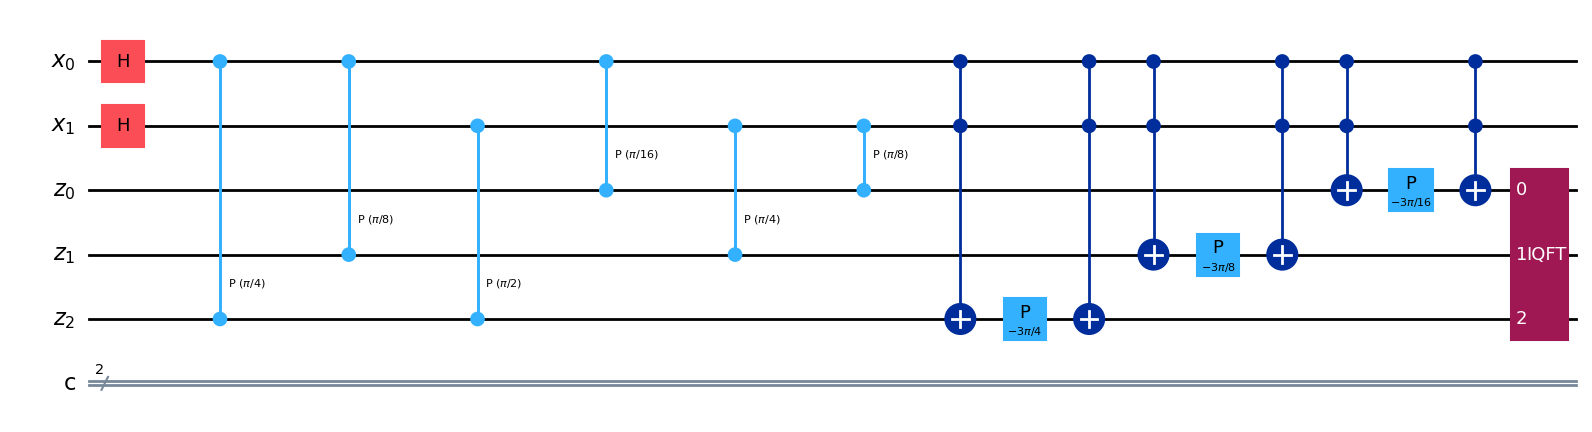

In [3]:
# Step 4: Apply Inverse QFT to value register; decode the P info classical Binary info which is hidden inside the Q P of Zs; i/p are still in superposition

from qiskit.circuit.library import QFT
qc.append(QFT(num_qubits=m_value, do_swaps=False, inverse=True), z)
qc.draw('mpl')

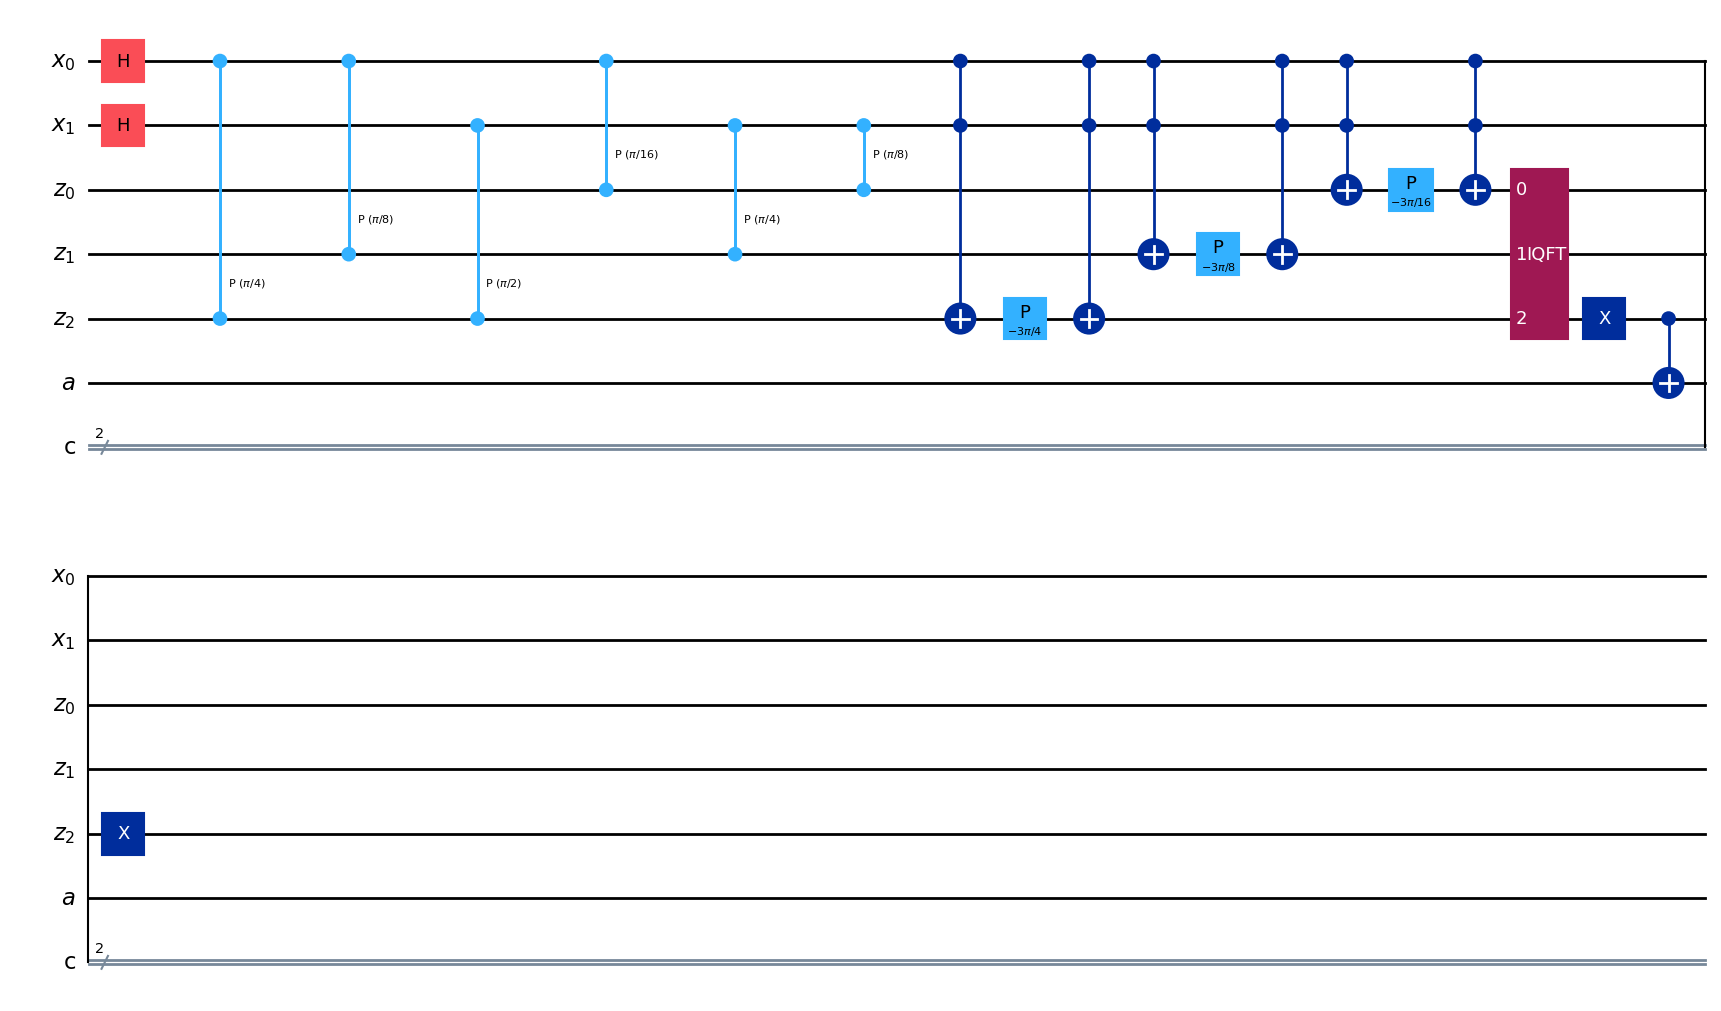

In [4]:
# Step 5: Oracle - Mark good solutions
# Create an ancilla qubit if not already created
from qiskit import QuantumRegister

a = QuantumRegister(1, name='a')  # 1 ancilla qubit
qc.add_register(a)

# Flip ancilla if MSB (z[m_value-1]) is 0
qc.x(z[m_value-1])          # Invert MSB; to trick Qiskit's control logic coz it only triggers at 1 but MSB must be 0 gor good value
qc.cx(z[m_value-1], a[0])    # Controlled flip ancilla
qc.x(z[m_value-1])           # Undo invert; cant change the value register permanently

qc.draw('mpl')

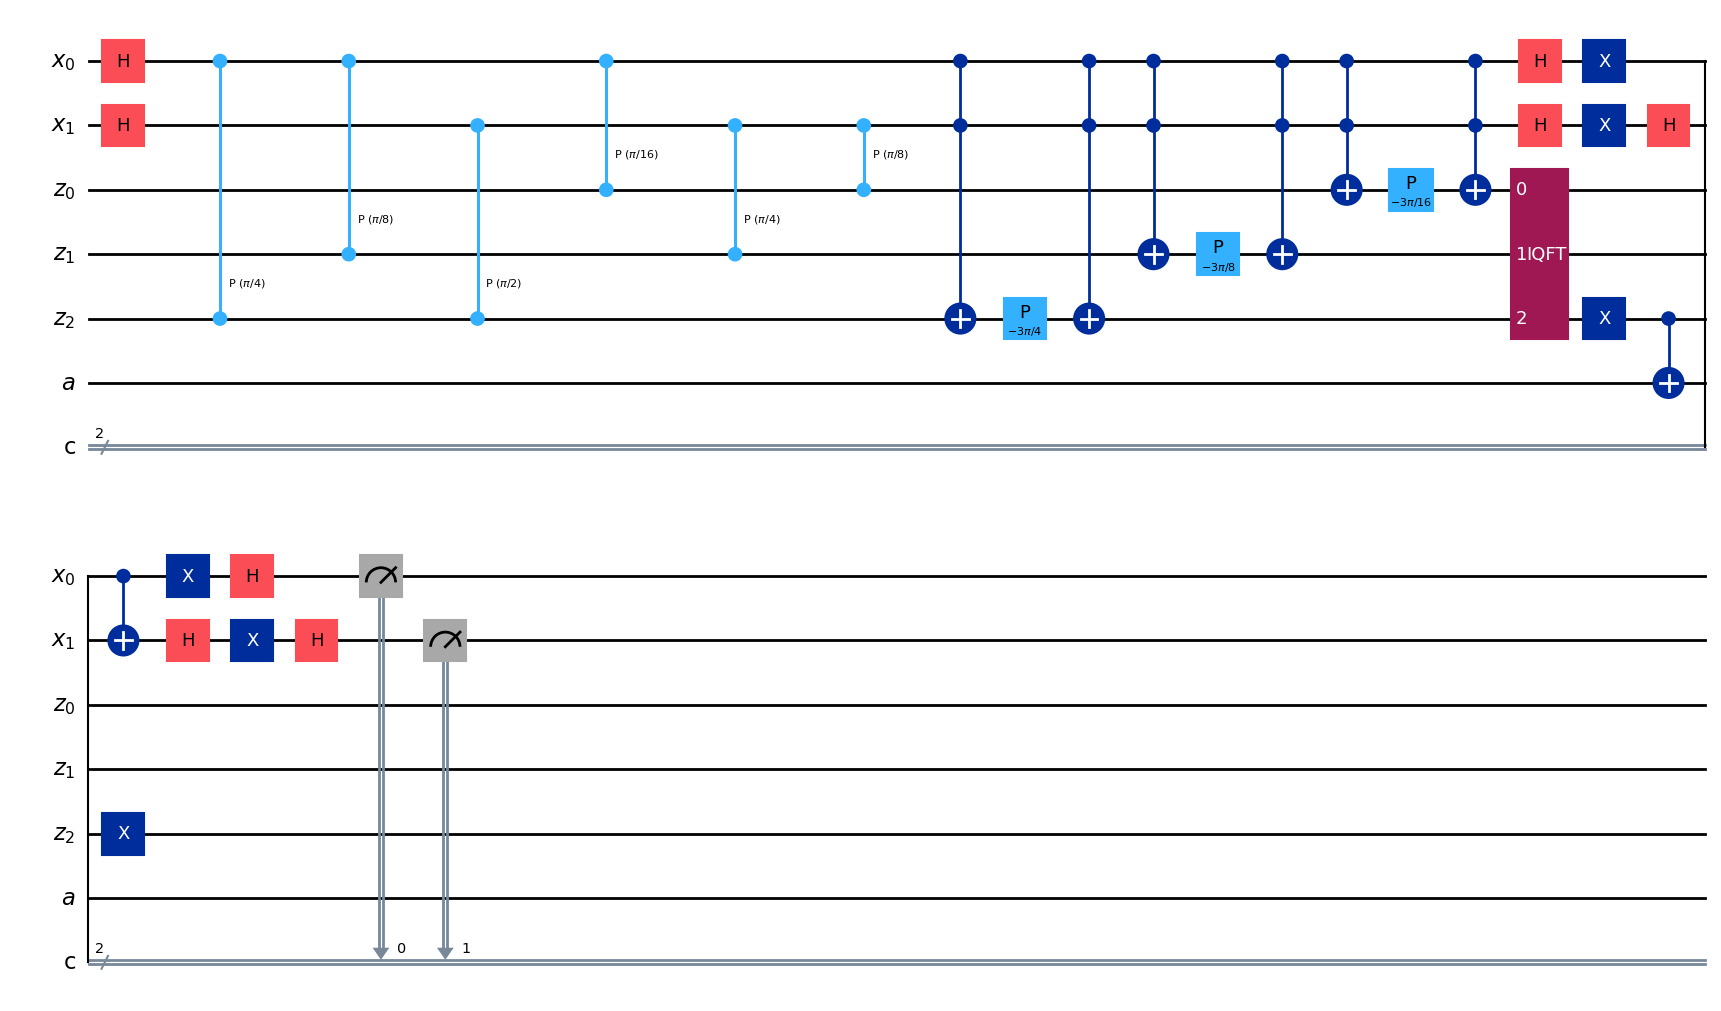

In [5]:
# Apply Hadamard
qc.h(x)
# Apply X
qc.x(x)
# Multi-controlled Z
qc.h(x[-1])
if len(x) > 1:
    qc.mcx(x[:-1], x[-1])
else:
    qc.z(x[0])
qc.h(x[-1])
# Apply X again
qc.x(x)
# Apply Hadamard again
qc.h(x)

# Step 7: Measurement
qc.measure(x, c)

# Final: Draw circuit
qc.draw('mpl')  